## Principal Component Analysis (PCA) for single cell RNA data (scRNA)

PCA is performed on scRNA-seq data for 6148 samples. This is very high dimensional data with 24990 features. The following steps are taken to visualize and optimize PCA:
- logarithmically transform data
- filter for top 60% of high variance genes
- standardize data
- perform and visualize PCA for 2D and 3D
- analyze scree plot to determine optimal number of principal components
- save dataframe with optimal number of principal components for future k-means clustering

In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [12]:
#read in data
data = pd.read_csv("cleaned_cgga_6148_scRNA.csv")
data.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0,0,0,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,1,0
1,0,0,0,66,0,0,0,0,0,0,...,0,1,0,0,25,0,0,14,0,0
2,18,0,0,105,0,0,0,0,0,0,...,7,5,0,0,0,0,1,85,0,20
3,21,0,0,0,0,0,0,0,0,0,...,13,21,0,0,69,0,0,44,0,11
4,30,0,0,0,0,0,0,0,0,0,...,17,0,0,0,14,0,1,26,9,22


In [13]:
# normalize data, this data comes in unique molecular identifier units(UMI)
# UMI varies widely, so log transformation is helpful

df_log = data.transform(np.log1p)

# Check the transformed data
df_log.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.000000,0.0,0.0,4.330733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.302585,0.693147,0.000000
1,0.000000,0.0,0.0,4.204693,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.693147,0.0,0.0,3.258097,0.0,0.000000,2.708050,0.000000,0.000000
2,2.944439,0.0,0.0,4.663439,0.0,0.0,0.0,0.0,0.0,0.0,...,2.079442,1.791759,0.0,0.0,0.000000,0.0,0.693147,4.454347,0.000000,3.044522
3,3.091042,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.639057,3.091042,0.0,0.0,4.248495,0.0,0.000000,3.806662,0.000000,2.484907
4,3.433987,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.890372,0.000000,0.0,0.0,2.708050,0.0,0.693147,3.295837,2.302585,3.135494


In [66]:
# remove low variability genes

gene_variance = df_log.var(axis=0)

# set a variance threshold 
threshold = gene_variance.quantile(0.4)  # keep top 60% most variable genes

# filter out genes with variance below the threshold
df_filtered = df_log.loc[:, gene_variance > threshold]

# check the filtered data
df_filtered.shape  # (cells, high-variance genes)
df_filtered.head()

# about 6000 genes were removed to improve PCA

,A1BG,A2M,A2M-AS1,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.000000,4.330733,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.302585,0.693147,0.000000
1,0.000000,4.204693,0.0,0.0,0.0,2.197225,0.000000,0.0,0.0,2.890372,...,0.000000,0.000000,0.693147,0.0,0.0,3.258097,0.000000,2.708050,0.000000,0.000000
2,2.944439,4.663439,0.0,0.0,0.0,1.098612,1.386294,0.0,0.0,1.945910,...,0.000000,2.079442,1.791759,0.0,0.0,0.000000,0.693147,4.454347,0.000000,3.044522
3,3.091042,0.000000,0.0,0.0,0.0,3.555348,1.791759,0.0,0.0,2.397895,...,3.401197,2.639057,3.091042,0.0,0.0,4.248495,0.000000,3.806662,0.000000,2.484907
4,3.433987,0.000000,0.0,0.0,0.0,1.791759,0.000000,0.0,0.0,2.484907,...,1.386294,2.890372,0.000000,0.0,0.0,2.708050,0.693147,3.295837,2.302585,3.135494


In [67]:
# standardize data, will be converted to np array

scaler = StandardScaler() # instantiate scaler function
df=scaler.fit_transform(df_filtered) # scale data
print(df)
print(type(df))
print(df.shape)

[[-0.67165604  1.56709775 -0.1518172  ...  0.3406199   0.21673071
  -0.73397565]
 [-0.67165604  1.49793422 -0.1518172  ...  0.59297444 -0.49111684
  -0.73397565]
 [ 1.48690541  1.74966655 -0.1518172  ...  1.67983982 -0.49111684
   1.5699202 ]
 ...
 [-0.67165604  0.07381532 -0.1518172  ... -1.0924696  -0.49111684
  -0.73397565]
 [ 1.74451439 -0.80934691 -0.1518172  ...  0.50391093 -0.49111684
  -0.73397565]
 [-0.67165604 -0.04863237 -0.1518172  ... -1.0924696  -0.49111684
  -0.73397565]]
<class 'numpy.ndarray'>
(6148, 14994)


In [68]:
# step 1: perform PCA
pca = PCA(n_components=3) #instantiate pca with 3 components
result = pca.fit_transform(df) # project the original data into the PCA space
# check transformation
print("PCA Transformed Data:\n", result[:5])  # show first 5 rows
print("Shape of Transformed Data:", result.shape)


PCA Transformed Data:
 [[-34.26372098  24.06479219  -5.1010646 ]
 [-27.76570474  31.78310995  -4.35955573]
 [ 77.11508194  74.68685552   4.18472697]
 [ 97.33032646  -4.31367638 -13.81249017]
 [ 40.14195146  -7.41751839  -8.10887208]]
Shape of Transformed Data: (6148, 3)


In [69]:
# step 2: explore variance 
# print eigenvalues (variance explained)
print("Eigenvalues (Explained Variance):", pca.explained_variance_)

# check how much variance each component captures
print("Relative Eigenvalues (Explained Variance Ratio):", pca.explained_variance_ratio_)

# verify covariance matches eigenvalues
cov_matrix = np.cov(result.T)  # compute covariance of the PCA-transformed data
print("Covariance Matrix of PCA Result:\n", cov_matrix)  # diagonal should match eigenvalues


Eigenvalues (Explained Variance): [2072.71124504  371.67075288  284.6653666 ]
Relative Eigenvalues (Explained Variance Ratio): [0.13821356 0.02478393 0.0189822 ]
Covariance Matrix of PCA Result:
 [[ 2.07271125e+03  3.61016280e-14 -1.02090669e-14]
 [ 3.61016280e-14  3.71670753e+02  4.55709075e-14]
 [-1.02090669e-14  4.55709075e-14  2.84665367e+02]]


In [70]:
# step 3: print the eigenvectors and compare to original data shape
eigenvectors = pca.components_
print("Eigenvectors (Principal Axes):\n", eigenvectors)
print("Shape of Eigenvector Matrix:", eigenvectors.shape)  # should be (3, 22491)
print("Original Data Shape:", data.shape)  # should be (6148, 24990)


Eigenvectors (Principal Axes):
 [[ 0.00856285 -0.0005156   0.00074347 ...  0.01304202  0.00684577
   0.00945586]
 [-0.00510285  0.03636545  0.00611142 ...  0.01011731  0.00622803
  -0.00178034]
 [ 0.01341081  0.00025915  0.00166393 ... -0.0075519   0.00216825
   0.00493013]]
Shape of Eigenvector Matrix: (3, 14994)
Original Data Shape: (6148, 24990)


In [71]:
# step 4: PCA transformation manually using the eigenvectors
transformation = df @ eigenvectors.T  # multiply original data by eigenvectors

# step 5: compare manually transformed data with PCA result
print("Manually Transformed Data (should match PCA result):\n", transformation[:5])

# it matches!

Manually Transformed Data (should match PCA result):
 [[-34.26372098  24.06479219  -5.1010646 ]
 [-27.76570474  31.78310995  -4.35955573]
 [ 77.11508194  74.68685552   4.18472697]
 [ 97.33032646  -4.31367638 -13.81249017]
 [ 40.14195146  -7.41751839  -8.10887208]]


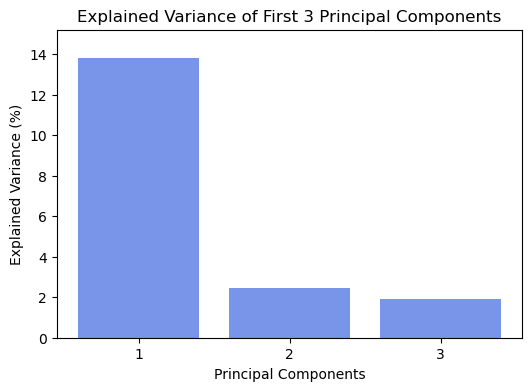

In [72]:
#bar plot for percent variance explained
plt.figure(figsize=(6, 4))
plt.bar(range(1, 4), pca.explained_variance_ratio_ * 100, color='royalblue', alpha=0.7)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance of First 3 Principal Components")
plt.xticks([1, 2, 3])
plt.ylim(0, max(pca.explained_variance_ratio_) * 110) 
plt.show()

/var/folders/xp/jfl5n1qn405fcy_ccvcwy6mc0000gn/T/ipykernel_3008/1440107039.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(x, y, z, cmap="RdYlGn", edgecolor='k', s=50)


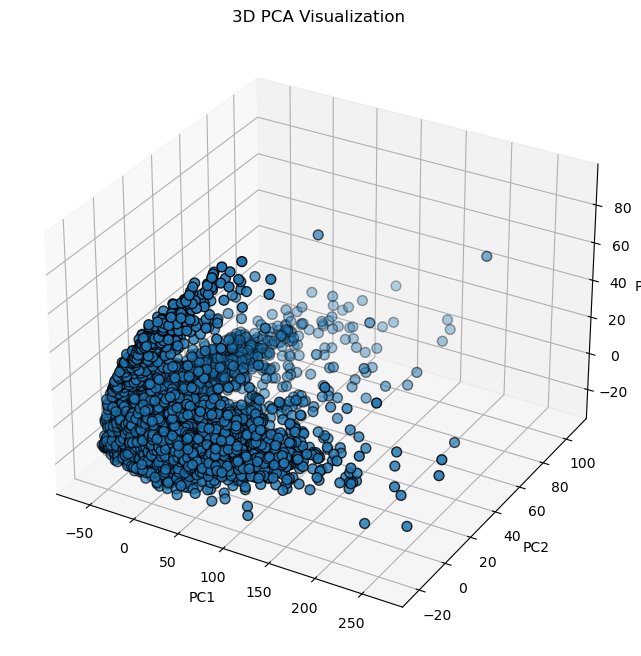

In [73]:
# visualize 3D dataset from PCA
# create a 3D scatter plot
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(projection='3d')

# extract principal components
x = result[:, 0]  # PC1
y = result[:, 1]  # PC2
z = result[:, 2]  # PC3


ax2.scatter(x, y, z, cmap="RdYlGn", edgecolor='k', s=50)  

# label axes
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('3D PCA Visualization')

plt.show()


/var/folders/xp/jfl5n1qn405fcy_ccvcwy6mc0000gn/T/ipykernel_3008/613193799.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap="coolwarm", edgecolor='k', alpha=0.7)


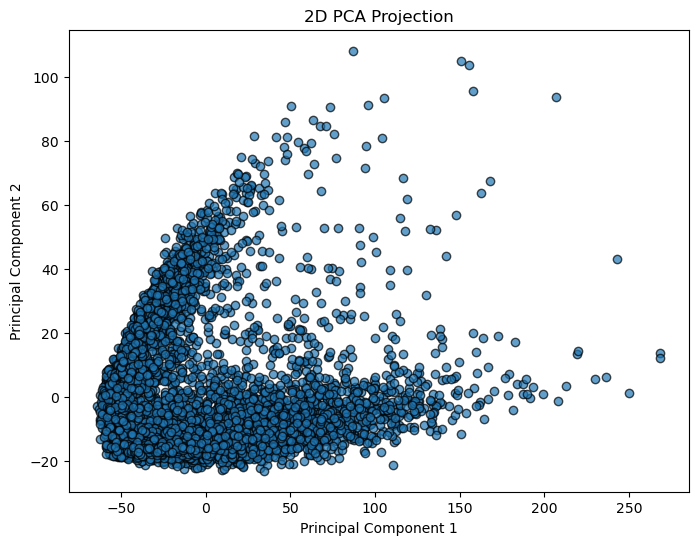

In [74]:
# repeat for 2D

pca_2d = PCA(n_components=2)
result_2D = pca_2d.fit_transform(df)

# extract PC1 and PC2
x = result_2D[:, 0]  # PC1
y = result_2D[:, 1]  # PC2

# create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, cmap="coolwarm", edgecolor='k', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection")
plt.show()


In [75]:
# print eigenvalues (variance explained)
print("Eigenvalues (Explained Variance):", pca_2d.explained_variance_)

# check how much variance each component captures
print("Relative Eigenvalues (Explained Variance Ratio):", pca_2d.explained_variance_ratio_)

Eigenvalues (Explained Variance): [2072.71124504  371.67075288]
Relative Eigenvalues (Explained Variance Ratio): [0.13821356 0.02478393]


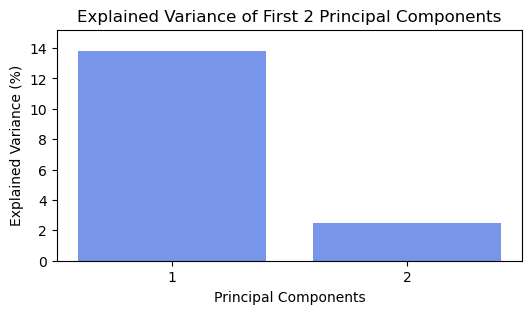

In [76]:
#bar plot for percent variance explained in 2D
plt.figure(figsize=(6, 3))
plt.bar(range(1, 3), pca_2d.explained_variance_ratio_ * 100, color='royalblue', alpha=0.7)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance of First 2 Principal Components")
plt.xticks([1, 2])
plt.ylim(0, max(pca_2d.explained_variance_ratio_) * 110) 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


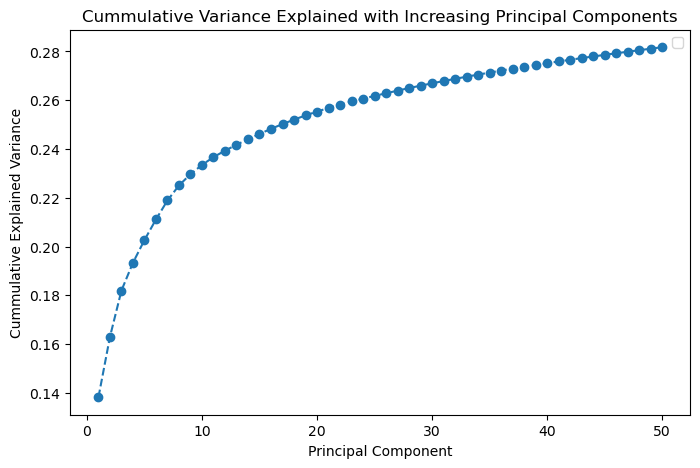

In [77]:
# only caputuring about 11% of the data with 2D and 3D, performing elbow plot to find optimal number of PCs

# perform PCA with enough components to see the variance distribution
num_components = 50  
pca_50 = PCA(n_components=num_components)
pca_50.fit(df)  

# explained variance ratio
explained_variance_ratio = pca_50.explained_variance_ratio_

# create scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_components + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--')

plt.xlabel('Principal Component')
plt.ylabel('Cummulative Explained Variance')
plt.title('Cummulative Variance Explained with Increasing Principal Components')
plt.legend()
plt.show()

In [79]:
# 15 principal components is the optimal number of components according to the scree plot
# note that 15 components only span 25% of the data, PCA is not optimal for this extremely high dimensional, high variance data
# perform pca with 15 pcs for k means clustering

pca_15D = PCA(n_components=16)
result_15D = pca_15D.fit_transform(df)

print(result_15D)

[[-34.26372098  24.06479218  -5.10106477 ...   1.96850821   0.93289932
   -4.00113909]
 [-27.76570474  31.78310994  -4.35955585 ...   1.4055801    1.02519583
   -3.96214496]
 [ 77.11508194  74.68685552   4.18472728 ...  -0.14437726  -8.22783788
   16.21690976]
 ...
 [-56.65387024  -3.96493479  -2.61430772 ...   1.87929265  -1.29641959
   -0.46136753]
 [-14.05774426 -15.56640244  38.48472568 ...   0.83928579  -2.72047899
    1.12568772]
 [-53.78032652 -15.64441157   7.33405082 ...   0.62661291  -2.65477418
    0.9573799 ]]


In [80]:
# for 15D
# print eigenvalues (variance explained)
print("Eigenvalues (Explained Variance):", pca_15D.explained_variance_)

# check how much variance each component captures
print("Relative Eigenvalues (Explained Variance Ratio):", pca_15D.explained_variance_ratio_)

Eigenvalues (Explained Variance): [2072.71124504  371.67075288  284.6653666   170.90607757  139.4315401
  126.7044148   116.88984273   92.29547085   69.1835625    56.77900773
   48.15547383   39.63216006   36.41667485   33.66414299   32.67324283
   31.61564814]
Relative Eigenvalues (Explained Variance Ratio): [0.13821356 0.02478393 0.0189822  0.01139644 0.00929764 0.00844897
 0.00779451 0.00615449 0.00461333 0.00378617 0.00321113 0.00264277
 0.00242835 0.00224481 0.00217873 0.00210821]


In [81]:
# save 10D PCA matrix for k-means clustering 


# convert PCA result to DataFrame and save as CSV
pd.DataFrame(result_15D).to_csv("pca_15D_for_clustering.csv", index=False)

